In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.helpers import n_clust_obs_f_f, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from functools import partial
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Set up networks

In [2]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [3]:
# Cosine Decay with Restarts
initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'checkpoints_fixed'
checkpoint_path = os.path.join(os.getcwd(), trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam, lr_schedule_restart),
    checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\01_calibration_validation\checkpoints_fixed\ckpt-10


# Calibration curves without uncertainty

ECE = 0.048


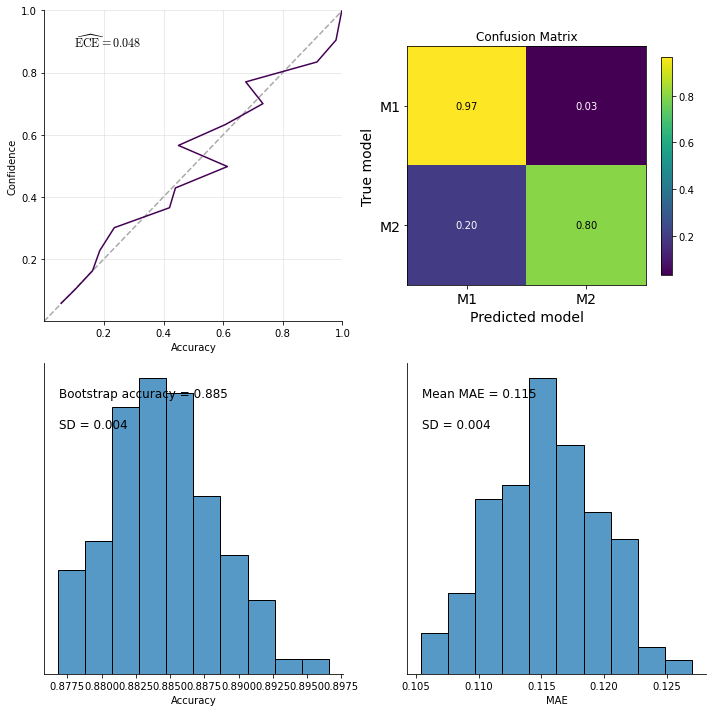

In [4]:
# Validation
n_val = 5000
m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
val_data = {'X' : x_val, 'm' : m_val}

perf_tester(evidence_net, summary_net, val_data, n_cal_bins=15)

ECE = 0.038
ECE = 0.044
ECE = 0.031
ECE = 0.033
ECE = 0.036
ECE = 0.046
ECE = 0.044
ECE = 0.033
ECE = 0.041
ECE = 0.030


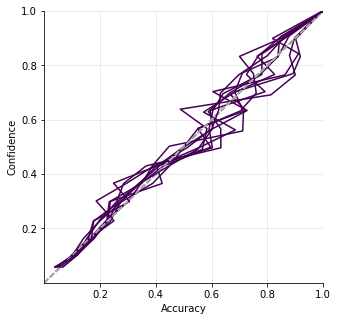

In [5]:
# Plot repeated calibration curves

fig, ax = plt.subplots(figsize=(5,5))

for i in range(10):
    m_val, _, x_val = simulator(n_val, n_clust_obs_f_f())
    val_data = {'X' : x_val, 'm' : m_val}

    # Compute model predictions in chunks so GPU memory does not blow-up
    m_soft = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'][:, 1] for x_chunk in tf.split(val_data['X'], 20)], axis=0).numpy()
    m_hard = (m_soft > 0.5).astype(np.int32)
    m_true = val_data['m'][:, 1]
    plot_calibration_curve(m_true, m_soft, n_bins=15, ax=ax, show_ece=False)

# Calibration curves with uncertainty

In [6]:
def plot_calibration_curve_uncertainty(m_true, pm_samples_model, narrow_ci, wide_ci, n_bins, ax, 
                                       xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True):
    """ Plots a calibration curve for a single model with uncertainty (median line and two credible intervals).
        Caution: Can throw a ValueError if one of the samples produces an empty bin (i.e. less than 15 bins) -> repeat.

    Parameters
    ----------
    m_true : np.array
            One-dimensional array that indicates whether the model is true or not. 
    pm_samples_model : np.array
            Two-dimensional array containing the posterior samples of the model's probability for each data set.
    narrow_ci : list
            The quantiles of the narrow credible interval.
    wide_ci : list
            The quantiles of the wide credible interval.
    n_bins : int
            Number of calibration bins.
    ax : matplotlib Axes
            Matplot axes object specifying the plot that should be used.
    xlabel : boolean
            Controls if the x-axis label is shown.
    ylabel : boolean
            Controls if the y-axis label is shown.
    title : str
            An optional title that can be provided.
    show_ece : boolean
            Controls if the Expected Calibration Error is shown.
    show_legend : boolean
            Controls if a legend is shown.
    """

    n_samples = pm_samples_model.shape[1]

    # Get bins & ECE for each sample from the learned dirichlet distribution
    probs_true = np.zeros((n_samples, n_bins))
    probs_pred = np.zeros((n_samples, n_bins))

    for n in range(n_samples):
        m_soft = pm_samples_model[:, n]
        probs_true[n, :], probs_pred[n, :] = calibration_curve(m_true, m_soft, n_bins=n_bins)
    cal_err = np.mean(np.abs(probs_true - probs_pred))

    # Get median for each bin 
    probs_true_median = np.squeeze(np.quantile(probs_true, q=[0.5], axis=0))
    probs_pred_median = np.squeeze(np.quantile(probs_pred, q=[0.5], axis=0))

    # Get quantiles for each bin 
    # Narrow credible interval
    probs_true_narrow = np.quantile(probs_true, q=narrow_ci, axis=0)
    probs_pred_narrow = np.quantile(probs_pred, q=narrow_ci, axis=0)
    # Wide credible interval
    probs_true_wide = np.quantile(probs_true, q=wide_ci, axis=0)
    probs_pred_wide = np.quantile(probs_pred, q=wide_ci, axis=0)

    # Plot median curve and diagonal
    ax.plot((0,1), (0,1), '--', color='darkgrey')
    ax.plot(probs_true_median, probs_pred_median, color='#440154FF')

    # Plot credible intervals
    ax.fill(np.append(probs_true_narrow[0,:], probs_true_narrow[1,:][::-1]),
            np.append(probs_pred_narrow[0,:], probs_pred_narrow[1,:][::-1]),
            color='#440154FF', alpha=0.3, label='{:.0%} CI'.format(narrow_ci[1]-narrow_ci[0]))
    ax.fill(np.append(probs_true_wide[0,:], probs_true_wide[1,:][::-1]),
            np.append(probs_pred_wide[0,:], probs_pred_wide[1,:][::-1]),
            color='#440154FF', alpha=0.2, label='{:.0%} CI'.format(wide_ci[1]-wide_ci[0]))   

    # Format plot
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    if xlabel:
            ax.set_xlabel('Accuracy')
    if ylabel:
            ax.set_ylabel('Confidence')
    ax.set_title(title, fontsize=14)
    ax.grid(alpha=.3)
    if show_ece:
            ax.text(0.1, 0.9, r'$\widehat{{\mathrm{{ECE}}}} = {0:.3f}$'.format(cal_err),
                    horizontalalignment='left', verticalalignment='center',
                    transform=ax.transAxes, size=12)
    if show_legend:
            ax.legend(loc="lower right", fontsize=12)
    sns.despine(ax=ax)

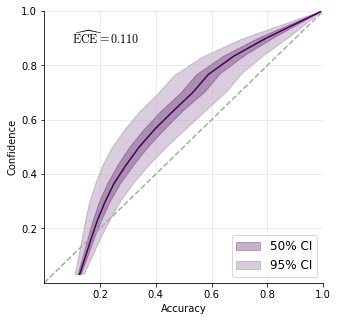

In [7]:
# Get Alphas
alphas = tf.concat([evidence_net(summary_net(x_chunk)) for x_chunk in tf.split(val_data['X'], 500)], axis=0).numpy()

# Sample from dirichlet
n_samples = 10000
n_datasets = alphas.shape[0]
pm_samples = np.stack([np.random.dirichlet(alphas[n, :], size=n_samples) for n in range(n_datasets)], axis=0)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
narrow_ci = [0.25, 0.75]
wide_ci = [0.025, 0.975]

m_true = val_data['m'][:, 1]
pm_samples_model = pm_samples[:, :, 1]
plot_calibration_curve_uncertainty(m_true, pm_samples_model, narrow_ci=narrow_ci, wide_ci=wide_ci, n_bins=15, ax=ax)

# Investigate behavior of single dirichlet samples

In [8]:
# Get bins & ECE for each sample from the learned dirichlet distribution
n_bins=15

probs_true = np.zeros((n_samples, n_bins))
probs_pred = np.zeros((n_samples, n_bins))

for n in range(n_samples):
    m_soft = pm_samples_model[:, n]
    probs_true[n, :], probs_pred[n, :] = calibration_curve(m_true, m_soft, n_bins=n_bins)
cal_err = np.mean(np.abs(probs_true - probs_pred))

(array([   8.,   64.,  368., 1331., 2496., 2912., 1890.,  745.,  164.,
          22.]),
 array([0.07933435, 0.08509911, 0.09086388, 0.09662865, 0.10239341,
        0.10815818, 0.11392295, 0.11968771, 0.12545248, 0.13121725,
        0.13698201]),
 <BarContainer object of 10 artists>)

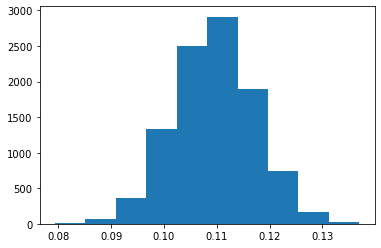

In [9]:
# ECE distribution over samples
plt.hist(np.mean(np.abs(probs_true - probs_pred), axis=1))